# Example BIU Usage

In [1]:
where = '/exports/molepi/tgehrmann/data/'
import biu as biu
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

List the available datasets

In [2]:
biu.db.list()

CADD:
Available versions:
 * GRCh37

ClinVar:
Available versions:
 * GRCh37
 * GRCh38

GnomAD
Available versions:
 * GRCh37

Genomes:
Available genomes:
 * GRCh37
 * Ensembl_GRCh37
 * RefSeq_GRCh37
 * RefSeq_GRCh38

GTeX:
Available versions:
 * v7


## Open a genome object and load the GFF file

Load the genome, and get the GFF file and parse it

In [3]:
hg = biu.db.Genome("GRCh37", where="%s/hg19" % where)
print(hg)

Genome object
 Where: /exports/molepi/tgehrmann/data/hg19
 Genome : GRCh37
 Files:
  * [X] gff : /exports/molepi/tgehrmann/data/hg19/genome.gff3
  * [ ] cds : /exports/molepi/tgehrmann/data/hg19/genome.fa
  * [ ] chr_1 : /exports/molepi/tgehrmann/data/hg19/chr1.fa.gz
  * [ ] chr_2 : /exports/molepi/tgehrmann/data/hg19/chr2.fa.gz
  * [ ] chr_3 : /exports/molepi/tgehrmann/data/hg19/chr3.fa.gz
  * [ ] chr_4 : /exports/molepi/tgehrmann/data/hg19/chr4.fa.gz
  * [ ] chr_5 : /exports/molepi/tgehrmann/data/hg19/chr5.fa.gz
  * [ ] chr_6 : /exports/molepi/tgehrmann/data/hg19/chr6.fa.gz
  * [ ] chr_7 : /exports/molepi/tgehrmann/data/hg19/chr7.fa.gz
  * [ ] chr_8 : /exports/molepi/tgehrmann/data/hg19/chr8.fa.gz
  * [ ] chr_9 : /exports/molepi/tgehrmann/data/hg19/chr9.fa.gz
  * [ ] chr_10 : /exports/molepi/tgehrmann/data/hg19/chr10.fa.gz
  * [ ] chr_11 : /exports/molepi/tgehrmann/data/hg19/chr11.fa.gz
  * [ ] chr_12 : /exports/molepi/tgehrmann/data/hg19/chr12.fa.gz
  * [ ] chr_13 : /exports/molepi/

In [4]:
#download(["gff"]) #(optional, will be done automatically, unless downloadOnDemand=False)
print(hg.getGFF())

GFF3 object
 Where: /exports/molepi/tgehrmann/data/hg19/genome.gff3
 Entries: 2626677
 Top level statistics:
  * chromosome : 25
  * pseudogene : 13985
  * lincRNA_gene : 7109
  * gene : 26998
  * processed_transcript : 514
  * snRNA_gene : 1923
  * miRNA_gene : 3111
  * RNA : 2038
  * snoRNA_gene : 1459
  * rRNA_gene : 533
  * V_gene_segment : 97
  * J_gene_segment : 74
  * C_gene_segment : 5
  * VD_gene_segment : 37
  * supercontig : 59
  * mt_gene : 22



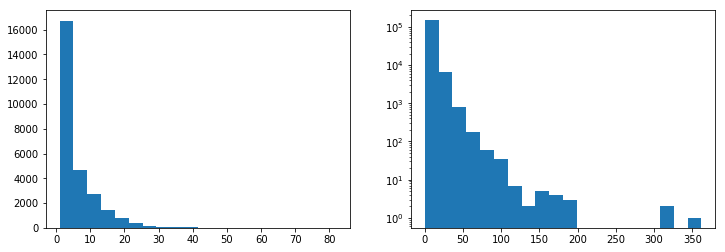

In [5]:
nTranscriptsPerGene = []
nExonsPerTranscript = []
for gene in hg.getGFF().topLevel['gene']:
    transcripts = [ cid for (i, cid) in hg.getGFF().index[gene][1] ]
    nTranscriptsPerGene.append(len(transcripts))
    for trans in transcripts:
        nExonsPerTranscript.append(len(hg.getGFF().index[trans][1]))
    #efor
#efor

fig, axes = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axes = axes.flatten()
axes[0].hist(nTranscriptsPerGene, bins=20)
axes[1].hist(nExonsPerTranscript, bins=20, log=True)
plt.show()

## Access the ClinVar database

In [6]:
cv = biu.db.ClinVar("GRCh37", where='%s/clinVar' % where)
print(cv)

ClinVar object
 Where: /exports/molepi/tgehrmann/data/clinVar
 Version: GRCh37
 Objects:
  * [ ] _vcfSource
  * [ ] _summarySource
 
 Files:
  * [X] vcf : /exports/molepi/tgehrmann/data/clinVar/clinVar.vcf.bgz
  * [X] vcf_tbi : /exports/molepi/tgehrmann/data/clinVar/clinVar.vcf.bgz.tbi
  * [X] sum : /exports/molepi/tgehrmann/data/clinVar/summary.tsv.bgz
  * [X] sum_tbi : /exports/molepi/tgehrmann/data/clinVar/summary.tsv.bgz.tbi



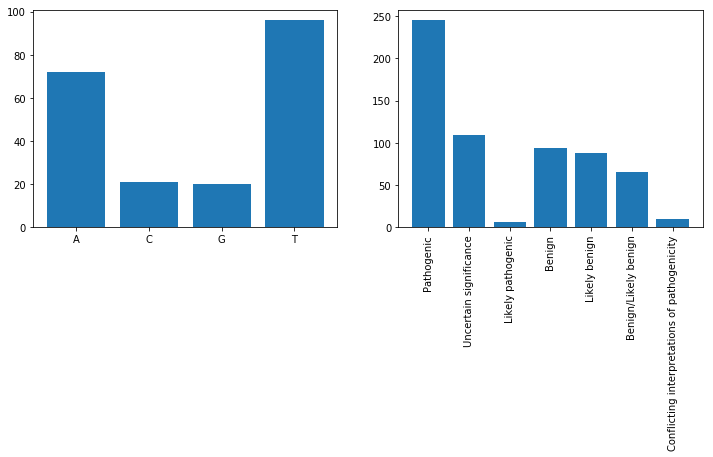

In [7]:
alts = { n : 0 for n in 'ACGT'}
for record in cv.queryVCF(1, 949422, 1049422):
    for alt in record.ALT:
        alt = alt.sequence
        if alt in alts:
            alts[alt] += 1

cImpact = {}
for record in cv.querySummary(1, 949422, 1049422):
    if record.clinicalsignificance not in cImpact:
        cImpact[record.clinicalsignificance] = 0
    cImpact[record.clinicalsignificance] += 1

fig, axes = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
axes = axes.flatten()

nbars = axes[0].bar([1,2,3,4], alts.values(), tick_label=list(alts.keys()))

nbars = axes[1].bar([ x + 1 for x in range(len(cImpact.keys())) ], cImpact.values(), tick_label=list(cImpact.keys()))
plt.xticks(rotation=90)
plt.show()

## Access the CADD database
If you have pre-existing files elsewhere, you can tell the system where they are exactly with the "localCopy" argument, and it will make a symbolic link to our local copy.

In [8]:
cadd = biu.db.CADD(where="%s/cadd" % where,
                   localCopy = {"tsv" : "/exports/molepi/tgehrmann/GAVIN-reimp/CADD/cadd.tsv.bgz", 
                                "tsv_tbi" : "/exports/molepi/tgehrmann/GAVIN-reimp/CADD/cadd.tsv.bgz.tbi"})
print(cadd)

Same symbolic link already exists for 'tsv'
Same symbolic link already exists for 'tsv_tbi'
CADD object
 Where: /exports/molepi/tgehrmann/data/cadd/GRCh37
 Version: GRCh37
 Objects:
  * [ ] _source
 
 Files:
  * [S] tsv : /exports/molepi/tgehrmann/data/cadd/GRCh37/cadd.tsv.bgz -> /exports/molepi/tgehrmann/GAVIN-reimp/CADD/cadd.tsv.bgz
  * [S] tsv_tbi : /exports/molepi/tgehrmann/data/cadd/GRCh37/cadd.tsv.bgz.tbi -> /exports/molepi/tgehrmann/GAVIN-reimp/CADD/cadd.tsv.bgz.tbi



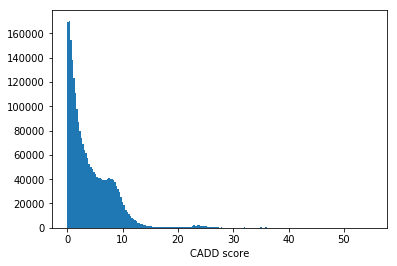

In [16]:
plt.hist([ float(p) for p in cadd.query(1, 0, 1000000).values() ], bins=200)
plt.xlabel("CADD score")
plt.show()

## Access the GnomAD database

In [10]:
gnomad = biu.db.Gnomad(where = "%s/cadd" % where,
                       localCopy = { "vcf" : "/exports/molepi/tgehrmann/GAVIN-reimp/gnomAD/gnomad.vcf.bgz",
                                     "vcf_tbi" : "/exports/molepi/tgehrmann/GAVIN-reimp/gnomAD/gnomad.vcf.bgz.tbi"})
print(gnomad)

Same symbolic link already exists for 'vcf'
Same symbolic link already exists for 'vcf_tbi'
Gnomad object
 Where: /exports/molepi/tgehrmann/data/cadd
 Version: GRCh37
 Objects:
  * [ ] _vcfSource
  * [ ] _covSource
 
 Files:
  * [S] vcf : /exports/molepi/tgehrmann/data/cadd/gnomad.vcf.bgz -> /exports/molepi/tgehrmann/GAVIN-reimp/gnomAD/gnomad.vcf.bgz
  * [S] vcf_tbi : /exports/molepi/tgehrmann/data/cadd/gnomad.vcf.bgz.tbi -> /exports/molepi/tgehrmann/GAVIN-reimp/gnomAD/gnomad.vcf.bgz.tbi
  * [ ] chr_1_cov : /exports/molepi/tgehrmann/data/cadd/gnomad.coverage.chr.1.tsv.bgz
  * [ ] chr_1_cov_tbi : /exports/molepi/tgehrmann/data/cadd/gnomad.coverage.chr.1.tsv.bgz.tbi
  * [ ] chr_2_cov : /exports/molepi/tgehrmann/data/cadd/gnomad.coverage.chr.2.tsv.bgz
  * [ ] chr_2_cov_tbi : /exports/molepi/tgehrmann/data/cadd/gnomad.coverage.chr.2.tsv.bgz.tbi
  * [ ] chr_3_cov : /exports/molepi/tgehrmann/data/cadd/gnomad.coverage.chr.3.tsv.bgz
  * [ ] chr_3_cov_tbi : /exports/molepi/tgehrmann/data/cadd/g

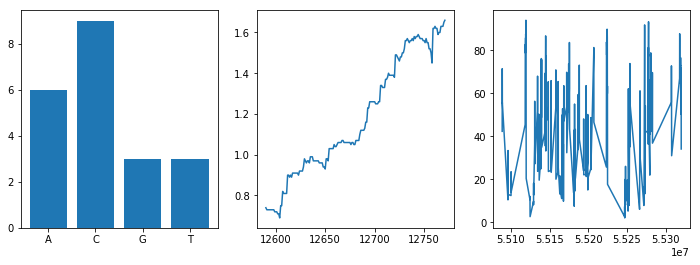

In [25]:
alts = { n : 0 for n in 'ACGT'}
for record in gnomad.queryVCF(1, 12590, 13000):
    for alt in record.ALT:
        alt = alt.sequence
        if alt in alts:
            alts[alt] += 1

x = []; y = []
for record in gnomad.queryCov(1, 12590, 13000):
    x.append(int(record.pos))
    y.append(float(record.mean))

gene = "gene:ENSG00000146648"
gEntry = hg.getGFF().getID(gene)
genex = []; geney=[]
for record in gnomad.queryCov(1, gEntry.start, gEntry.end):    
    genex.append(int(record.pos))
    geney.append(float(record.mean))

fig, axes = plt.subplots(figsize=(12,4), ncols=3, nrows=1)
axes = axes.flatten()

nbars = axes[0].bar([1,2,3,4], alts.values(), tick_label=list(alts.keys()))
axes[1].plot(x,y)
axes[2].plot(genex,geney)

## GTeX access

In [4]:
gtex = biu.db.GTeX(version="v7", 
                   where="/exports/molepi/tgehrmann/data/gtex", 
                   localCopy={"s_attr" : "/home/tgehrmann/data/gtexsAttr.tsv" })
print(gtex)

Same symbolic link already exists for 's_attr'
GTeX object
 Where: /exports/molepi/tgehrmann/data/gtex
 Note: You must provide your own local copies using the 'localCopy' option!
 Version: v7
 Objects:
  * [ ] _gTPMSource
  * [ ] _tTPMSource
  * [ ] _sAttrSource
  * [ ] _sPhenoSource
 
 Files:
  * [ ] g_tpm : /exports/molepi/tgehrmann/data/gtex/genes_TPM.tsv.gz
  * [ ] t_tpm : /exports/molepi/tgehrmann/data/gtex/transcripts_TPM.tsv.gz
  * [S] s_attr : /exports/molepi/tgehrmann/data/gtex/sample_attributes.tsv -> /home/tgehrmann/data/gtexsAttr.tsv
  * [ ] s_pheno : /exports/molepi/tgehrmann/data/gtex/sample_phenotypes.tsv



In [5]:
gtex._requiresAttrSource()
gtex._sAttrSource

,SAMPID,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
0,GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GTEX-1117F-0003-SM-6WBT7,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GTEX-1117F-0226-SM-5GZZ7,0.0,B1,"2 pieces, ~15% vessel stroma, rep delineated",6.8,Adipose Tissue,Adipose - Subcutaneous,0002190,1214.0,1125.0,...,14579275.0,12025354.0,0.003164,14634407.0,50.094357,0.003102,0.992826,NaN,0.0,50.126280
4,GTEX-1117F-0426-SM-5EGHI,0.0,B1,"2 pieces, !5% fibrous connective tissue, delin...",7.1,Muscle,Muscle - Skeletal,0011907,1220.0,1119.0,...,13134349.0,11578874.0,0.003991,13307871.0,50.328114,0.006991,0.994212,NaN,0.0,49.905170
5,GTEX-1117F-0526-SM-5EGHJ,0.0,B1,"2 pieces, clean, Monckebeg medial sclerosis, r...",8.0,Blood Vessel,Artery - Tibial,0007610,1221.0,1120.0,...,13169835.0,11015113.0,0.004285,13160068.0,49.981450,0.002867,0.992711,NaN,0.0,50.227848
6,GTEX-1117F-0626-SM-5N9CS,1.0,B1,"2 pieces, up to 4mm aderent fat/nerve/vessel, ...",6.9,Blood Vessel,Artery - Coronary,0001621,1243.0,1098.0,...,15148343.0,11624467.0,0.003379,15282444.0,50.220333,0.005335,0.991175,NaN,0.0,50.025043
7,GTEX-1117F-0726-SM-5GIEN,1.0,B1,"2 pieces, no abnormalities",6.3,Heart,Heart - Atrial Appendage,0006631,1244.0,1097.0,...,13583226.0,9262806.0,0.003451,13745609.0,50.297090,0.030579,0.994478,NaN,0.0,49.929870
8,GTEX-1117F-1326-SM-5EGHH,1.0,B1,"2 pieces, diffuse mesothelial hyperplasia; ~10...",5.9,Adipose Tissue,Adipose - Visceral (Omentum),0010414,1277.0,1066.0,...,13342709.0,9625148.0,0.004869,13393827.0,50.095592,0.010321,0.989115,NaN,0.0,50.058605
9,GTEX-1117F-2226-SM-5N9CH,1.0,B1,"1 piece vascular tissue, probably ovarian hilu...",6.6,Ovary,Ovary,0000992,1326.0,1020.0,...,15767801.0,12721979.0,0.003328,15920208.0,50.240480,0.002097,0.990144,NaN,0.0,49.962017


In [40]:
pTissues = {}
for i, row in gtex._sAttrSource.iterrows():
    if row["SMAFRZE"] != "RNASEQ":
        continue
    #fi
    personID = row["SAMPID"].split('-')[1]
    sampleType = row["SMTSD"]
    if personID not in pTissues:
        pTissues[personID] = []
    pTissues[personID].append(sampleType)

indivTissues = sorted(list(set(gtex._sAttrSource["SMTSD"])))
pairwiseTissueCounts = {}
for personID in pTissues:
    tissues = list(set(pTissues[personID]))
    for i, samplei in enumerate(tissues[:-1]):
        for j, samplej in enumerate(tissues[i+1:]):
            key = (samplei, samplej)
            if key not in pairwiseTissueCounts:
                pairwiseTissueCounts[key] = 0
            pairwiseTissueCounts[(samplei, samplej)] += 1

indivTissuesMap = { t: i for (i,t) in enumerate(list(indivTissues)) }

C = np.zeros([len(indivTissues), len(indivTissues)])
for (t1,t2) in pairwiseTissueCounts:
    C[indivTissuesMap[t1], indivTissuesMap[t2]] = int(pairwiseTissueCounts.get((t1,t2),0) +
                                                  pairwiseTissueCounts.get((t2,t1),0))
    C[indivTissuesMap[t2], indivTissuesMap[t1]] = int(pairwiseTissueCounts.get((t1,t2),0) +
                                                  pairwiseTissueCounts.get((t2,t1),0))

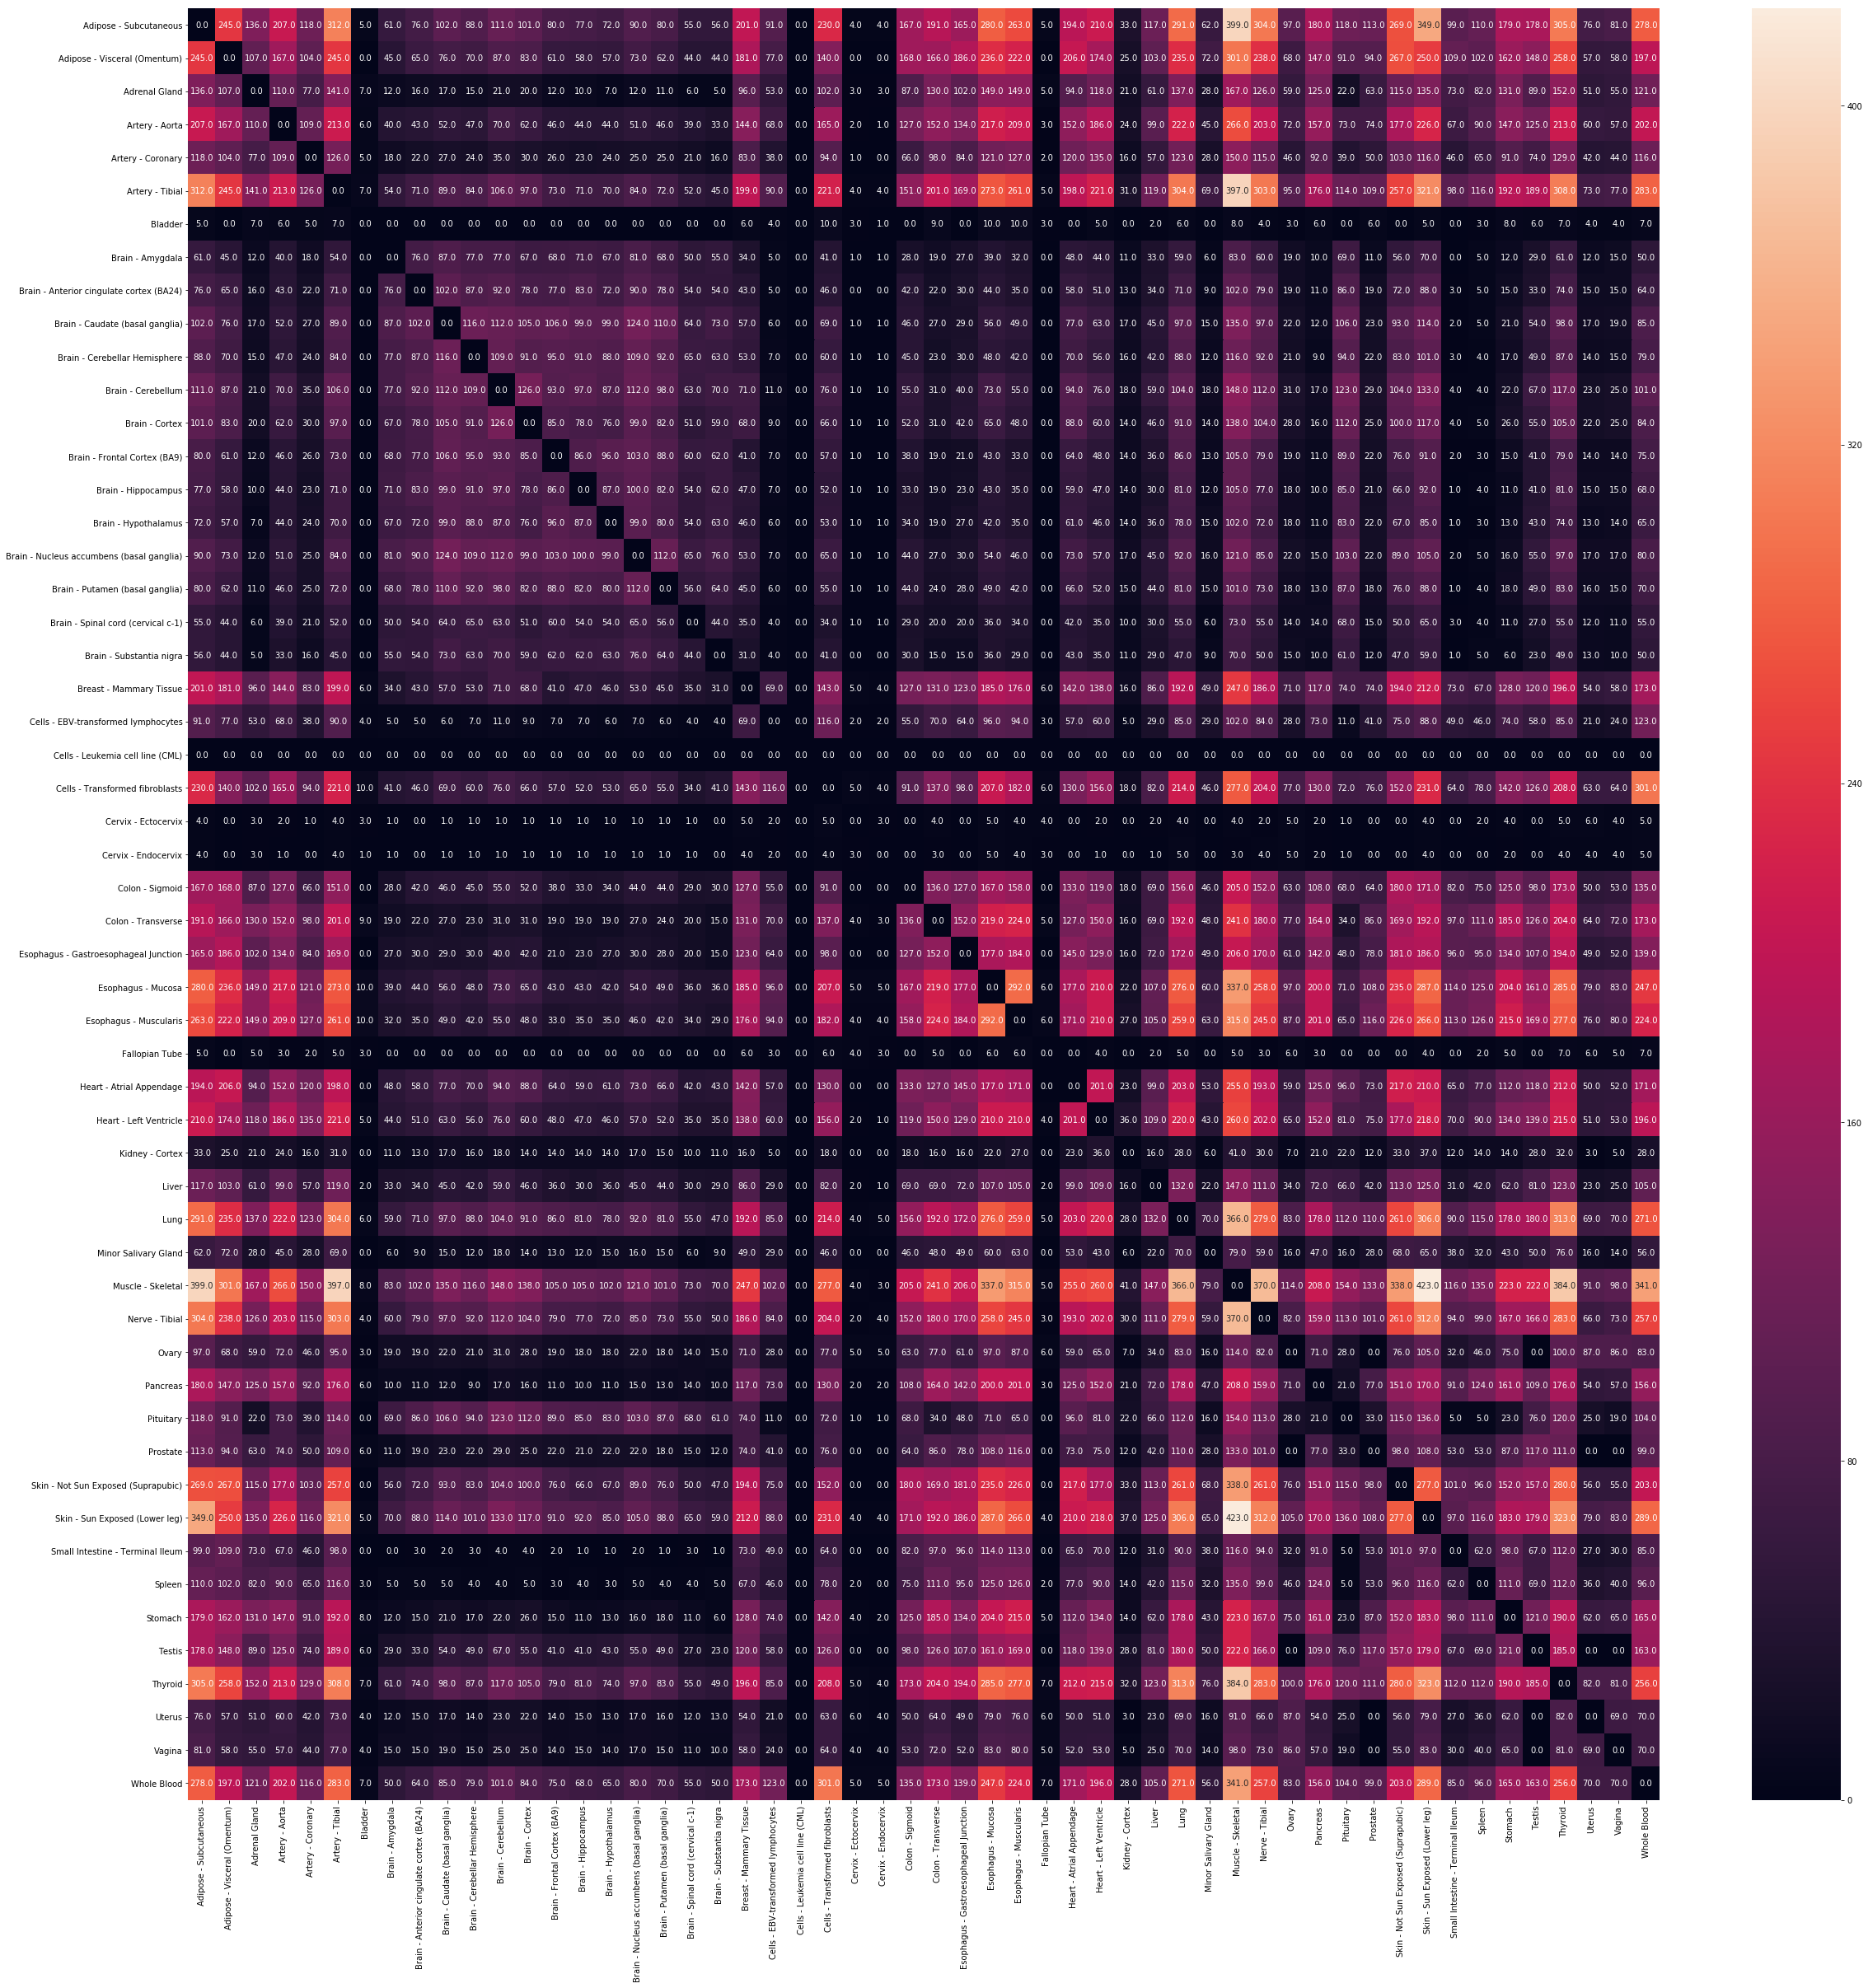

In [54]:
fig, ax = plt.subplots(figsize=(40,40))
sns.heatmap(C, ax = ax, xticklabels=indivTissues, yticklabels=indivTissues, annot=True, fmt='.1f')
plt.show()

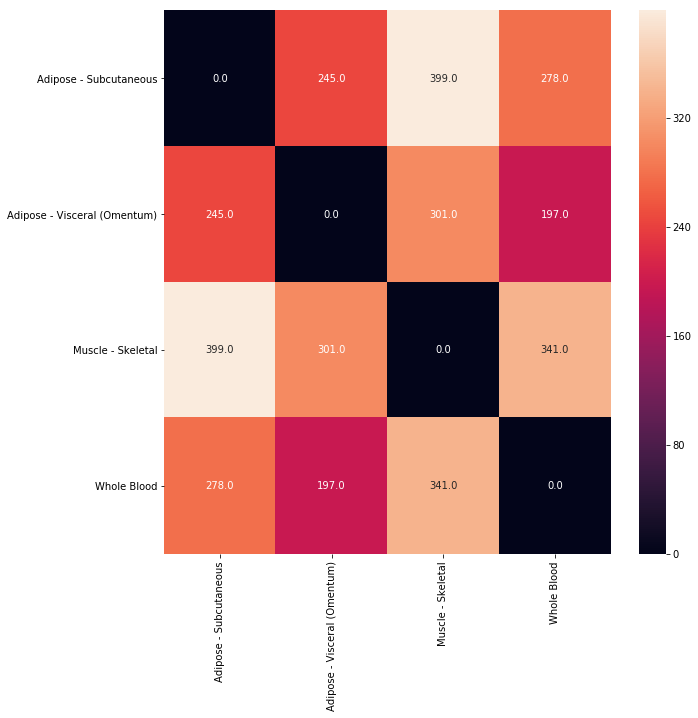

In [53]:
interestTissues = [ 'Adipose - Subcutaneous', 'Adipose - Visceral (Omentum)', 'Muscle - Skeletal', "Whole Blood" ]
interestTissuesIndex = [ indivTissuesMap[t] for t in interestTissues ]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(C[interestTissuesIndex,:][:,interestTissuesIndex], ax = ax, xticklabels=interestTissues, yticklabels=interestTissues, annot=True, fmt='.1f')
plt.show()